## Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# read training & evaluation datasets
dftrain = pd.read_csv('train.csv', skipinitialspace=True)
dfeval = pd.read_csv('eval.csv', skipinitialspace=True)

In [3]:
# preview training dataset
dftrain.head(10)

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y
5,0,male,2.0,3,1,21.0750,Third,unknown,Southampton,n
6,1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n
7,1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n
8,1,female,4.0,1,1,16.7000,Third,G,Southampton,n
9,0,male,20.0,0,0,8.0500,Third,unknown,Southampton,y


In [4]:
# info about evalutation dataset
dfeval.describe()

,survived,age,n_siblings_spouses,parch,fare
count,264.000000,264.000000,264.000000,264.000000,264.000000
mean,0.375000,28.720985,0.469697,0.386364,27.023880
std,0.485042,14.157538,0.978393,0.837775,34.973108
min,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,21.000000,0.000000,0.000000,7.925000
50%,0.000000,28.000000,0.000000,0.000000,13.250000
75%,1.000000,35.250000,1.000000,0.000000,27.900000
max,1.000000,74.000000,8.000000,6.000000,263.000000


In [5]:
dftrain.shape

(627, 10)

In [6]:
# isolate the survival info from datasets and store them seperately
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [7]:
type(y_train)

pandas.core.series.Series

In [8]:
# preview training dateset's survival information
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

Survival information are designated by 0 or 1, I assume 1 is survided?

## High-level Visualizations

<AxesSubplot:>

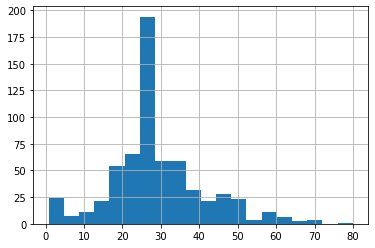

In [9]:
# what's training dataset's age distribution?
dftrain.age.hist(bins=20)

<AxesSubplot:>

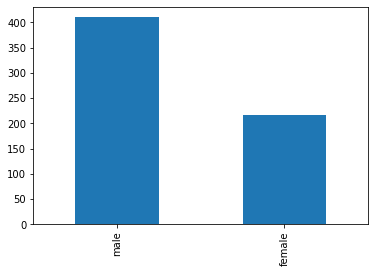

In [10]:
# what's training dataset's gender distributions?
dftrain.sex.value_counts().plot(kind='bar')

<AxesSubplot:>

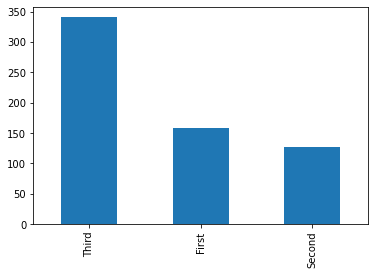

In [11]:
# what's training dateset's class distribution?
dftrain.loc[:,"class"].value_counts().plot(kind='bar')

<AxesSubplot:ylabel='sex'>

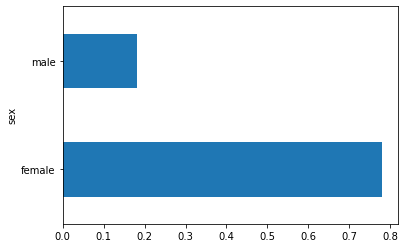

In [12]:
# what are the survival rates for male & female passengers in the training dataset?
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh')

After analyzing this information, we should notice the following:
- Most passengers are in their mid 20's
- Most passengers are male
- Most passengers are in "Third" class
- Females have a much higher chance of survival

In [14]:
dftrain['sex'].unique()

array(['male', 'female'], dtype=object)

## Data Processing & Preparations for ML

In [15]:
import tensorflow as tf

In [13]:
# define, identify and group columns 
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

In [18]:
feature_columns = []
for feature in CATEGORICAL_COLUMNS:
    # get unique values from each categorical column
    vocabulary = dftrain[feature].unique()
    # tensorflow use "tf.feature_column.categorical_column_with_vocabulary_list" to generate tensor features for categorial data
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature, vocabulary))
for feature in NUMERIC_COLUMNS:
    # tensorflow use "tf.feature_column.numeric_column" to generate tensor features for numeric data
    feature_columns.append(tf.feature_column.numeric_column(feature, dtype=tf.float32))
feature_columns

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.strin

In [49]:
# define an input function to act as data pipline for passing into the batches of datasets into the model
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        # tensorflow can only take df.data.Dataset object which can be created from dataset
        # dataframe can be converted to dictionary and along with label make a tuple for from_tensor_slices
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            # shuffles the data object entries
            ds = ds.shuffle(1000)
        # split the data object into batches and repeat the split of sets into number of epochs (repeated data)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function        

In [50]:
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

## Generating & Evaluating LP Model

I will use a linear regression model for the purpose of prediting either 0 or 1 for survivals.

In [51]:
# tensorflow linear estimator initialization by passing in the feature columns
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\212800~1\\AppData\\Local\\Temp\\tmpo5nmpiob', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [52]:
# train the model by passing in the input function which feeds the datasets by batches and epoches
linear_est.train(train_input_fn)

INFO:tensorflow:Calling model_fn.


C:\Users\212800015\Anaconda3\lib\site-packages\tensorflow_estimator\python\estimator\canned\linear.py:1468: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.bias = self.add_variable(


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\212800~1\AppData\Local\Temp\tmpo5nmpiob\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.6931472, step = 0
INFO:tensorflow:global_step/sec: 279.309
INFO:tensorflow:loss = 0.47759855, step = 100 (0.360 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200...
INFO:tensorflow:Saving checkpoints for 200 into C:\Users\212800~1\AppData\Local\Temp\tmpo5nmpiob\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 200...
INFO:tensorflow:Los

In [53]:
# evaluate the model using evaluation dataset and passing in input function
linear_est.evaluate(eval_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-12-22T15:56:33
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\212800~1\AppData\Local\Temp\tmpo5nmpiob\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.95943s
INFO:tensorflow:Finished evaluation at 2021-12-22-15:56:33
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.75, accuracy_baseline = 0.625, auc = 0.8298745, auc_precision_recall = 0.7836549, average_loss = 0.5067963, global_step = 200, label/mean = 0.375, loss = 0.50297505, precision = 0.6386555, prediction/mean = 0.46365473, recall = 0.7676768
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 200: C:\Users\212800~1\AppData\Local\Temp\tmpo5nmpiob\model.ckpt-200


{'accuracy': 0.75,
 'accuracy_baseline': 0.625,
 'auc': 0.8298745,
 'auc_precision_recall': 0.7836549,
 'average_loss': 0.5067963,
 'label/mean': 0.375,
 'loss': 0.50297505,
 'precision': 0.6386555,
 'prediction/mean': 0.46365473,
 'recall': 0.7676768,
 'global_step': 200}

An accurancy of only 75%....

## Application - LP Model Predictions

In [57]:
# predict the survival outcomes for all entries in the evaluation dataset
predictions = list(linear_est.predict(eval_input_fn))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\212800~1\AppData\Local\Temp\tmpo5nmpiob\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [60]:
predictions[0]

{'logits': array([-2.0335686], dtype=float32),
 'logistic': array([0.11572319], dtype=float32),
 'probabilities': array([0.88427675, 0.11572324], dtype=float32),
 'class_ids': array([0], dtype=int64),
 'classes': array([b'0'], dtype=object),
 'all_class_ids': array([0, 1]),
 'all_classes': array([b'0', b'1'], dtype=object)}

<AxesSubplot:title={'center':'Survial Predictions'}, ylabel='Frequency'>

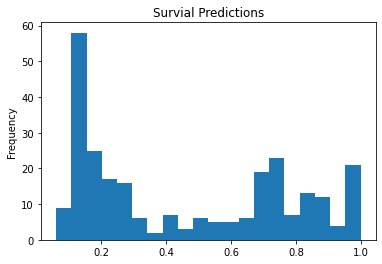

In [65]:
# what are the survival predictions for all passengers in the evaluation dataset?
pd.Series([i['probabilities'][1] for i in predictions]).plot(kind='hist', bins=20, title='Survial Predictions')

If we classifiy only survival predictions above 0.5 will be surviving, then most will not survive.

## Conclusions

- The model has an accuracy of 75%